In [3]:
import kagglehub

c:\Users\Samriddha\Desktop\MyAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

100%|██████████| 121M/121M [00:22<00:00, 5.58MB/s] 

Extracting files...


In [2]:
TRAIN_IMG_FOLDER_PATH = "images/train"
VALID_IMG_FOLDER_PATH = "images/validation"

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import random

In [4]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, + 20)),
    T.ToTensor() # Convert a PIL image or numpy.ndarray to tensor (h, w, c) --> (c, h, w)
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [5]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [6]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [7]:
print(trainset.class_to_idx)

import torch
torch.cuda.is_available()

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


True

In [8]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'happy')

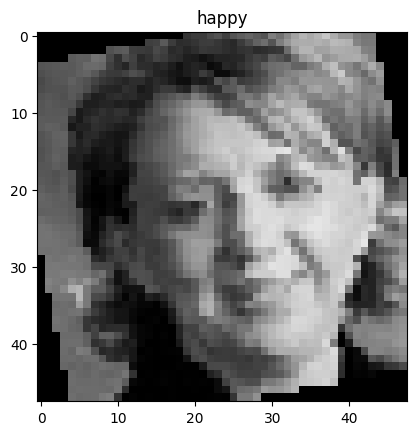

In [9]:
class_names = trainset.classes

index = random.randint(0, len(trainset)-1)
image, label = trainset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

Text(0.5, 1.0, 'surprise')

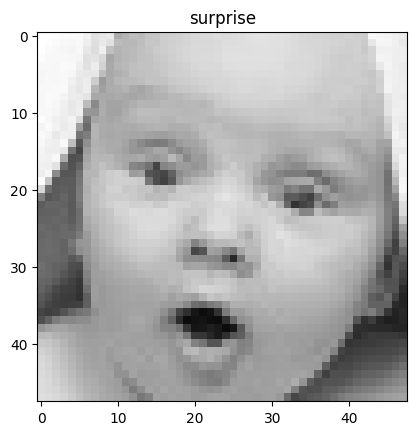

In [10]:
class_names = validset.classes

index = random.randint(0, len(validset)-1)
image, label = validset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

In [11]:
from torch.utils.data import DataLoader

In [12]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [13]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [14]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


In [15]:
import timm
from torch import nn

c:\Users\Samriddha\Desktop\MyAI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
class FaceModel(nn.Module):
    
    def __init__(self):
        super(FaceModel, self).__init__()
        
        self.eff_net = timm.create_model('efficientnet_b0',
                                        pretrained = True,
                                        num_classes = 7)
        
    def forward(self, images, labels = None):
        logits = self.eff_net(images)
        
        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss
        
        return logits

In [17]:
model = FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

In [18]:
from tqdm import tqdm

In [19]:
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class = y_pred.topk(1, dim = 1)
    equals = top_class = y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [20]:
def train_fn(model, dataloader, optimizer, current_epo):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})
        
    return total_loss / len(dataloader), total_acc / len(dataloader)
        

In [21]:
def eval_fn(model, dataloader, current_epo):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        logits, loss = model(images, labels)
        
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})
        
    return total_loss / len(dataloader), total_acc / len(dataloader)
        

In [22]:
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LR)

In [23]:
import numpy as np

In [24]:
best_valid_loss = np.inf

for i in range(50):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc = eval_fn(model, validloader, i)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss

EPOCH[TRAIN]1/15: 100%|██████████| 221/221 [00:03<00:00, 60.96it/s, loss=1.310490, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]2/15: 100%|██████████| 221/221 [00:04<00:00, 46.57it/s, loss=1.186982, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]3/15: 100%|██████████| 221/221 [00:04<00:00, 46.54it/s, loss=1.106931, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]4/15: 100%|██████████| 221/221 [00:04<00:00, 47.15it/s, loss=1.092666, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]5/15: 100%|██████████| 221/221 [00:04<00:00, 48.82it/s, loss=1.071339, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]6/15: 100%|██████████| 221/221 [00:04<00:00, 48.88it/s, loss=1.035421, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]8/15: 100%|██████████| 221/221 [00:04<00:00, 46.55it/s, loss=1.006822, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]9/15: 100%|██████████| 221/221 [00:04<00:00, 46.19it/s, loss=0.991307, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]10/15: 100%|██████████| 221/221 [00:04<00:00, 48.87it/s, loss=0.979832, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]12/15: 100%|██████████| 221/221 [00:04<00:00, 48.13it/s, loss=0.979226, acc=3.252121]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]50/15: 100%|██████████| 221/221 [00:04<00:00, 54.23it/s, loss=1.449062, acc=3.252121]


In [25]:
def view_classify(img, ps):
  
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']
    
    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)
    
    fig, (ax1, ax2) = plt.subplots(figsize = (5,9), ncols = 2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    
    return None

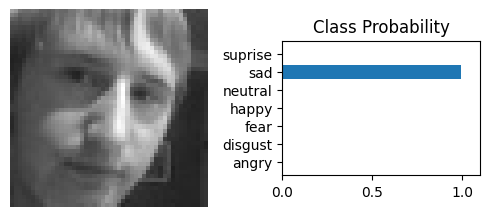

In [30]:
image, label = validset[78]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)